In [ ]:
pip install -q tensorflow-recommenders

In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from datetime import datetime
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import tensorflow_recommenders as tfrs


In [ ]:
tourism_rating = pd.read_csv('tourism_rating_edit.csv')
print(tourism_rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        10000 non-null  int64 
 1   Place_Id       10000 non-null  int64 
 2   Place_Name     10000 non-null  object
 3   Place_Ratings  10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB
None


In [ ]:
tourism_rating.head()

,User_Id,Place_Id,Place_Name,Place_Ratings
0,1,179,Candi Ratu Boko,3
1,1,344,Pantai Marina,2
2,1,5,Atlantis Water Adventure,5
3,1,373,Museum Kereta Ambarawa,3
4,1,101,Kampung Wisata Sosro Menduran,4


In [ ]:
tourism_rating['User_Id'] = tourism_rating['User_Id'].astype(str)
tourism_rating['Place_Name'] = tourism_rating['Place_Name'].astype(str)
tourism_rating['Place_Ratings'] = tourism_rating['Place_Ratings'].astype(np.float64)

In [ ]:
print(tourism_rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User_Id        10000 non-null  object 
 1   Place_Id       10000 non-null  int64  
 2   Place_Name     10000 non-null  object 
 3   Place_Ratings  10000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 312.6+ KB
None


In [ ]:
data_collaborative_filtering = tourism_rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Name,Place_Ratings
0,1,179,Candi Ratu Boko,3.0
1,1,344,Pantai Marina,2.0
2,1,5,Atlantis Water Adventure,5.0
3,1,373,Museum Kereta Ambarawa,3.0
4,1,101,Kampung Wisata Sosro Menduran,4.0
...,...,...,...,...
9995,300,425,Waterpark Kenjeran Surabaya,2.0
9996,300,64,Museum Sasmita Loka Ahmad Yani,4.0
9997,300,311,The Lodge Maribaya,3.0
9998,300,279,Masjid Agung Trans Studio Bandung,4.0


In [ ]:
print("my reviews: ")
tourism_rating[tourism_rating['User_Id']=="2"].head()

my reviews: 


,User_Id,Place_Id,Place_Name,Place_Ratings
30,2,147,Bentara Budaya Yogyakarta (BBY),2.0
31,2,2,Kota Tua,5.0
32,2,322,Bukit Jamur,4.0
33,2,23,Gereja Katedral,3.0
34,2,85,Taman Pintar Yogyakarta,4.0


In [ ]:
users_with_favorable_ratings = (tourism_rating['User_Id'].value_counts()
                                .loc[lambda x: x>5]
                                .loc[lambda x: x<100]
                                .index.values)

df = tourism_rating[tourism_rating['User_Id'].isin(users_with_favorable_ratings)]

## Data Prep and Modelling

In [ ]:
# create dicts of unique tourism and users for embeddings
df_tourism = df['Place_Name'].unique()
df_tourism = pd.DataFrame(df_tourism, columns = ['Place_Name'])

df_ratings = df[['User_Id', 'Place_Name']]
df_ratings = df_ratings.dropna()

# convert dataframes to tensors
tf_tourism_dict = tf.data.Dataset.from_tensor_slices(dict(df_tourism))
tf_ratings_dict = tf.data.Dataset.from_tensor_slices(dict(df_ratings))

In [ ]:
# map rows to a dictionary
ratings = tf_ratings_dict.map(lambda x: {
    "Place_Name": x["Place_Name"],
    "User_Id": x["User_Id"]
})

tourism_list = tf_tourism_dict.map(lambda x: x['Place_Name'])

In [ ]:
# for embedding
userid = ratings.map(lambda x: x['User_Id'])
unique_users = np.unique(np.concatenate(list(userid.batch(1000))))
unique_tourism = np.unique(np.concatenate(list(tourism_list.batch(1000))))

In [ ]:
# shuffle + test/train split
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(df), seed=42, reshuffle_each_iteration=False)
                          
train = shuffled.take(int(len(df)*0.8))
test = shuffled.skip(int(len(df)*0.8)).take(int(len(df)*0.2))

In [ ]:
# Extend the tfrs class
class TourismModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        
        embedding_dims = 32
        self.user_model =  tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary= unique_users, mask_token=None),
            tf.keras.layers.Embedding(len(unique_users)+1, embedding_dims)
        ])

        self.tourism_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_tourism, mask_token=None),
            tf.keras.layers.Embedding(len(unique_tourism)+1, embedding_dims)
        ])

        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tourism_list.batch(128).cache().map(self.tourism_model)
            ))
        
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features['User_Id'])
        tourism_embeddings = self.tourism_model(features['Place_Name'])
        return self.task(user_embeddings, tourism_embeddings)

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# initiate Model
model = TourismModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

In [ ]:
# Train Model

freq = 2
epochs = 20

history = model.fit(
                train.batch(8192),
                validation_data= test.batch(512),
                validation_freq=freq,
                epochs = epochs,
                verbose = 0,
                callbacks=[tensorboard_callback])

In [ ]:
model.evaluate(test.batch(8192), return_dict=True)

1/1 [==============================] - 0s 225ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0140 - factorized_top_k/top_50_categorical_accuracy: 0.1075 - factorized_top_k/top_100_categorical_accuracy: 0.2210 - loss: 24532.9766 - regularization_loss: 0.0000e+00 - total_loss: 24532.9766


{'factorized_top_k/top_1_categorical_accuracy': 0.001500000013038516,
 'factorized_top_k/top_5_categorical_accuracy': 0.00800000037997961,
 'factorized_top_k/top_10_categorical_accuracy': 0.014000000432133675,
 'factorized_top_k/top_50_categorical_accuracy': 0.10750000178813934,
 'factorized_top_k/top_100_categorical_accuracy': 0.22100000083446503,
 'loss': 24532.9765625,
 'regularization_loss': 0,
 'total_loss': 24532.9765625}

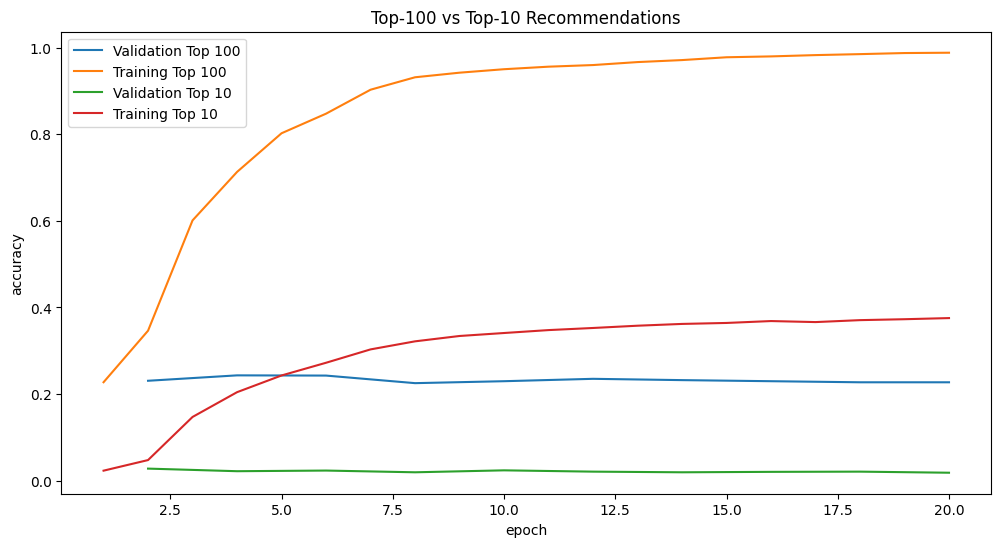

In [ ]:
#notice how back the accuracy is when only prediction the top 10 since no scores are input
plt.figure(figsize=(12,6))
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* freq for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label = "Validation Top 100")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_100_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_100_categorical_accuracy"])),
                     history.history["factorized_top_k/top_100_categorical_accuracy"], label = "Training Top 100")
plt.plot(epochs, history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "Validation Top 10")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_10_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_10_categorical_accuracy"])),
                     history.history["factorized_top_k/top_10_categorical_accuracy"], label = "Training Top 10")
plt.title("Top-100 vs Top-10 Recommendations")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
# Save Model

# ScaNN can be used in production instead of brute force to speed up prediction times
# Since this is a small dataset  I'll just use brute force
# "k" dictates the number of recommendations to be pulled in production
brute_force = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=100)
brute_force.index_from_dataset(
    tourism_list.batch(128).map(lambda Place_Name: (Place_Name, model.tourism_model(Place_Name)))
)

# Need to call it to set the shapes.The string could be anything
_ = brute_force(np.array(["1"]))

#tf.saved_model.save(
#  brute_force,
#  'models/tourism_retrieval_model')

In [ ]:
# Get Result
_, tourism = brute_force(tf.constant(["1"]))
print(f"Top 10 recommendations for user x : {tourism[0][:10]}")

Top 10 recommendations for user x : [b'Gua Pawon' b'Curug Tilu Leuwi Opat' b'Masjid Pusdai' b'Curug Anom'
 b'Pantai Ngrawe (Mesra)' b'Taman Hutan Raya Ir. H. Juanda'
 b'Museum Taman Prasasti' b'Margasatwa Muara Angke'
 b'Museum Konferensi Asia Afrika' b'Kampoeng Rawa']


## Ranking

In [ ]:
# fill any NaNs with blanks (tensorflow hates nans)
df.fillna(value='', inplace=True)

In [ ]:
# convert dataframes to tensors- 
tf_dict_df = tf.data.Dataset.from_tensor_slices(dict(tourism_rating))

# map rows to a dictionary
tourism_ratings = tf_dict_df.map(lambda x: {
    "User_Id": x["User_Id"],
    "Place_Name": x["Place_Name"],
    "Place_Ratings": x["Place_Ratings"],
})

In [ ]:
feature_names = ["User_Id", "Place_Name", "Place_Ratings"]

vocabularies = {}

# come up with vocab lists for string variables (doesn't really handle review text now)
# floats will automatically get converted to integers
for feature_name in feature_names:
    vocab = tourism_ratings.batch(1000000).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [ ]:
# test/train split

tf.random.set_seed(2001)
dataset_train_split = int(len(tourism_ratings)*0.8)
dataset_test_split = int(len(tourism_ratings)*0.2)

shuffled = tourism_ratings.shuffle(dataset_train_split, seed=2001, reshuffle_each_iteration=False)

train = shuffled.take(dataset_train_split)
test = shuffled.skip(dataset_train_split).take(dataset_test_split)

cached_train = train.shuffle(100000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Modelling

In [ ]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()
        
        self.embedding_dimension = 32
        
        str_features = ["User_Id", "Place_Name", "Place_Ratings"]
        
        self._all_features = str_features
        self._embeddings = {}
        
        # compute embeddings for string features
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.StringLookup(
                    vocabulary=vocabulary, mask_token=None),
                 tf.keras.layers.Embedding(len(vocabulary)+1, 
                                                self.embedding_dimension)
                ])
        
        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None
            
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]
        
        self._logit_layer = tf.keras.layers.Dense(1)
        
        
        self.task = tfrs.tasks.Ranking(
                        loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )
        
    def call(self, features):
        #concat embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
            
        x = tf.concat(embeddings, axis=1)
        
        # build cross network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
            
        # build deep network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)
            x = tf.keras.layers.Dropout(0.2)(x)

        return self._logit_layer(x)
    
    
    def compute_loss(self, features, training=False):
        labels = features.pop("score")
        scores = self(features)
        return self.task(
                    labels=labels,
                    predictions=scores,
        )